##### Author: Pablo Iañez Picazo
##### Biomedical Data Science lab

In [1]:
# Load all the necessary libraries
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

# Supress all warnings
import warnings

warnings.filterwarnings("ignore")

from methods import hsc_spatial_stats as hsc
from globals import batches_out

In [2]:
# Set visual properties for plotting
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_style("whitegrid")

In [4]:
# Set up some parameters
res = 0.1
norm = "z_score"
folder = "data/preprocessed"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "young_compressed_8um",
    "young_compressed_5um",
]

palette = {
    "Young": (0.00392, 0.45098, 0.69803),
    "Aged": (0.00784, 0.61960, 0.45098),
    "Aged + Ri": (0.8, 0.47058, 0.73725),
    "8μm": (0.79215, 0.56862, 0.38039),
    "5μm": (0.87058, 0.56078, 0.01960),
}

In [5]:
# Prepare a couple of utils functions to fix labels and plotting aesthetics
def reduce_xticks(xticklabels):
    for i, label in enumerate(xticklabels):
        if i % 5 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)


def fix_labels(df):
    """
    Fix the label for each HSC biological condition in the dataframe from the
    folder ID name to new names for plotting
    """

    labels_dict = {
        "young": "Young",
        "aged": "Aged",
        "Aged_treated_RhoAi": "Aged + Ri",
        "Young_compressed_8um": "8μm",
        "Young_compressed_5um": "5μm",
        "Young_compressed_3um": "3μm",
    }

    for old, new in labels_dict.items():
        df["condition"] = [c.replace(old, new) for c in df["condition"]]

    return df

young


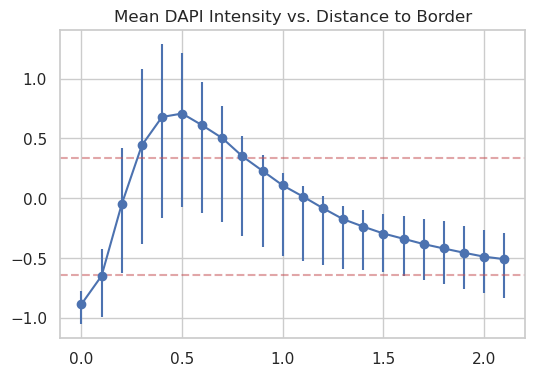

aged


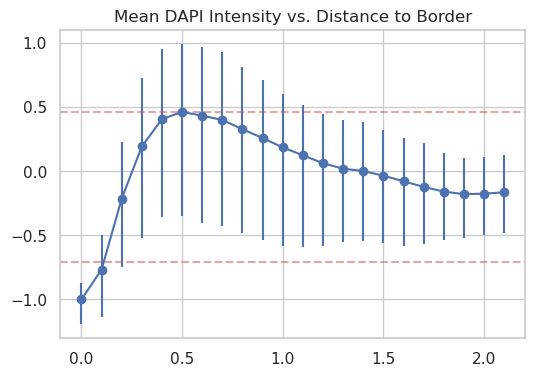

aged_treated_RhoAi


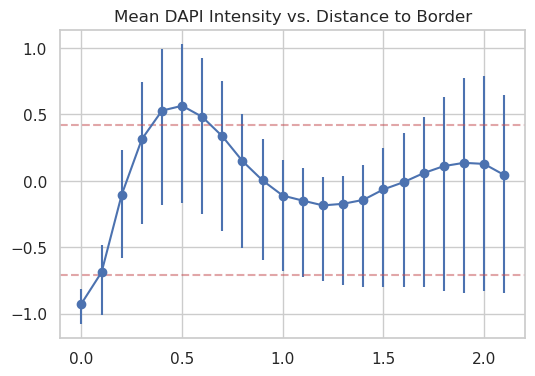

young_compressed_8um


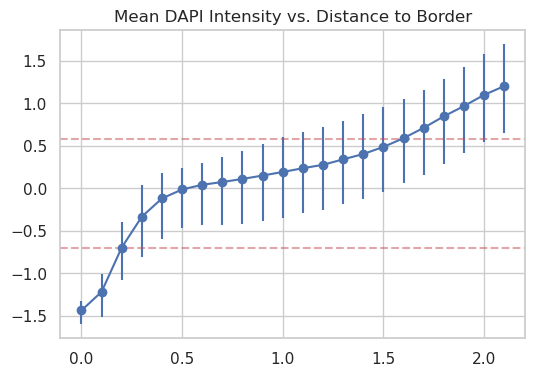

young_compressed_5um


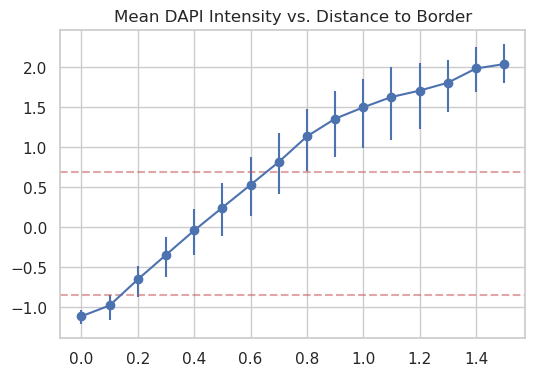

In [7]:
nuc_df = pd.DataFrame()

for cond in conditions:
    # Lists .npz files within containing folder with a given prefix
    npz_ims = glob(f"{folder}/3D_res={res}_norm={norm}_npz/{cond}/*.npz")
    print(cond)

    for i, npz in enumerate(npz_ims[:1]):
        image = np.load(npz, allow_pickle=True)
        nuc_mask = image["nuc_mask"].astype(int)
        im = image["img"]

        # ---------gets distance near nuclear border
        dist2bord = hsc.distance_transform_edt(nuc_mask)

        # --------plots mean intensity vs. distance continuously
        hsc.plot_intensity_profile_3D(
            im, nuc_mask, dist2bord, res, max_dist=22
        )

In [20]:
nuc_df = pd.DataFrame()

# With the round cells we can have more accurate information because the
# confined ones are not that big and does not reach the same distances
condition2distance = {
    "young": 17,
    "aged": 17,
    "aged_treated_RhoAi": 17,
    "young_compressed_8um": 17,
    "young_compressed_5um": 15,
}

for cond in conditions:
    # Lists .npz files within containing folder with a given prefix
    npz_ims = glob(f"{folder}/3D_res={res}_norm={norm}_npz/{cond}/*.npz")
    print(cond)

    for i, npz in enumerate(npz_ims):
        image = np.load(npz, allow_pickle=True)
        nuc_mask = image["nuc_mask"].astype(int)
        im = image["img"]
        metadata = image["metadata"].item()

        if metadata["batch_id"] in batches_out:
            continue

        # ---------gets distance near nuclear border
        dist2bord = hsc.distance_transform_edt(nuc_mask)

        # To solve the problem with intensities having different array lengths
        df = hsc.get_intensity_by_distance(
            im, nuc_mask, dist2bord, res, max_dist=condition2distance[cond]
        )
        df["condition"] = cond
        df["batch_id"] = metadata["batch_id"]
        df["year"] = metadata["batch_id"][:4]
        nuc_df = pd.concat([nuc_df, df])

    print(i)

nuc_df = fix_labels(nuc_df)

young
211
aged
177
aged_treated_RhoAi
155
young_compressed_8um
18
young_compressed_5um
25


In [21]:
nuc_df

,distance,mean_int,condition,batch_id,year
0,0.0,-1.012291,Young,20200130PlaminYoung slide1exp200122,2020
0,0.1,-0.782914,Young,20200130PlaminYoung slide1exp200122,2020
0,0.2,-0.213647,Young,20200130PlaminYoung slide1exp200122,2020
0,0.3,0.215885,Young,20200130PlaminYoung slide1exp200122,2020
0,0.4,0.463285,Young,20200130PlaminYoung slide1exp200122,2020
...,...,...,...,...,...
0,1.0,0.960835,5μm,20220525exp_20220610_RhoGTPTAZ_B_5um,2022
0,1.1,0.984314,5μm,20220525exp_20220610_RhoGTPTAZ_B_5um,2022
0,1.2,1.016486,5μm,20220525exp_20220610_RhoGTPTAZ_B_5um,2022
0,1.3,1.096378,5μm,20220525exp_20220610_RhoGTPTAZ_B_5um,2022


In [22]:
# Check number of existing measures per distance
nuc_df.distance.value_counts()

distance
0.0    532
0.5    532
0.1    532
0.7    532
0.6    532
0.8    532
0.4    532
0.3    532
0.2    532
0.9    531
1.0    531
1.1    531
1.2    531
1.3    531
1.4    527
1.5    505
1.6    505
Name: count, dtype: int64

In [23]:
nuc_df.condition.unique()

array(['Young', 'Aged', 'Aged + Ri', '8μm', '5μm'], dtype=object)

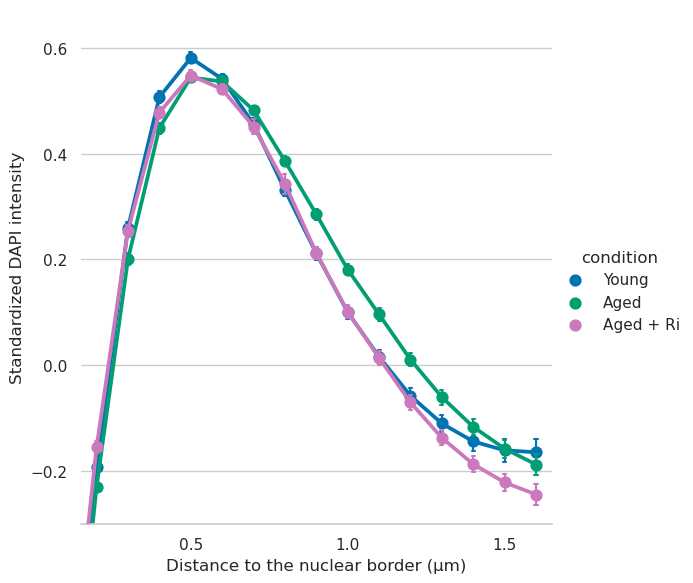

In [24]:
# Plot intensity vs distance profiles
subset_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri"])]
g = sns.catplot(
    data=subset_df,
    x="distance",
    y="mean_int",
    hue="condition",
    capsize=0.1,
    errorbar="se",
    errwidth=1.5,
    palette=palette,
    kind="point",
    height=6,
)

g.set(ylim=(-0.3, None))
g.set(xlim=(1.5, None))
reduce_xticks(plt.gca().get_xticklabels())
plt.xlabel("Distance to the nuclear border (μm)")
plt.ylabel("Standardized DAPI intensity")
sns.despine(left=True)
plt.show()

In [25]:
nums = subset_df.groupby("year").size().reset_index(name="Count")
# Calculate the overall number of observations
total = len(subset_df)

# Add a new column with the count proportion
nums["Proportion"] = nums["Count"] / total * 100

# Print the result
print(nums)

   year  Count  Proportion
0  2019    884   10.687946
1  2020   5296   64.030952
2  2021    867   10.482408
3  2022   1224   14.798694


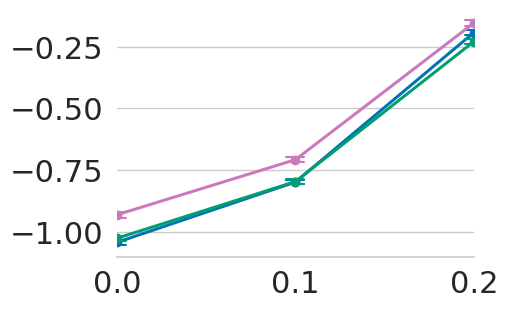

In [26]:
# Plot intensity vs distance profiles zooming in the range 0 - 0.2
subset_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri"])]

sns.set(font_scale=2, rc={"lines.linewidth": 1.2})
sns.set_style("whitegrid")
g = sns.catplot(
    data=subset_df,
    x="distance",
    y="mean_int",
    hue="condition",
    capsize=0.1,
    errorbar="se",
    errwidth=1.5,
    palette=palette,
    kind="point",
    height=4,
    aspect=1.5,
)
g.set(ylim=(-1.1, -0.1), xlim=(0, 2))
g.set(xlabel=None, ylabel=None)
g._legend.remove()
# reduce_xticks(plt.gca().get_xticklabels())
sns.despine(left=True)
plt.show()

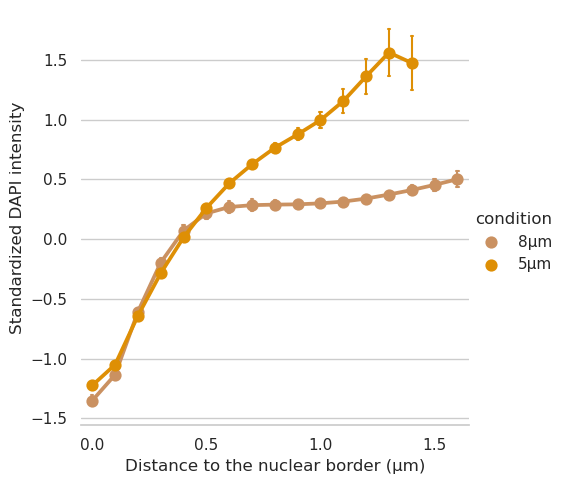

In [27]:
# Reset figure aesthetics that were changed before
sns.reset_orig()
sns.set(font_scale=1)
sns.set_style("whitegrid")

# Plot intensity vs distance profiles
subset_df = nuc_df[nuc_df["condition"].isin(["8μm", "5μm"])]
g = sns.catplot(
    data=subset_df,
    x="distance",
    y="mean_int",
    hue="condition",
    capsize=0.1,
    errorbar="se",
    errwidth=1.5,
    palette=palette,
    kind="point",
    height=5,
)
reduce_xticks(plt.gca().get_xticklabels())
plt.xlabel("Distance to the nuclear border (μm)")
plt.ylabel("Standardized DAPI intensity")
sns.despine(left=True)
plt.show()

In [17]:
nuc_df = pd.DataFrame()
index = 1

for cond in conditions:
    # Lists .npz files within containing folder with a given prefix
    npz_ims = glob(f"{folder}/3D_res={res}_norm={norm}_npz/{cond}/*.npz")
    print(cond)

    for i, npz in enumerate(npz_ims):
        image = np.load(npz, allow_pickle=True)
        nuc_mask = image["nuc_mask"].astype(int)
        im = image["img"]
        metadata = image["metadata"].item()

        if metadata["batch_id"] in batches_out:
            continue

        # ---------gets distance near nuclear border
        dist2bord = hsc.distance_transform_edt(nuc_mask)

        # Measure intensity in the distance interval specified in the tupples
        for interval in [(0, 5), (5, 10), (10, 15), (15, 20)]:
            imin, imax = interval

            df = pd.DataFrame(
                {
                    "intensity": [
                        hsc.get_intensity_in_distance(
                            im, nuc_mask, dist2bord, distance_range=interval
                        )
                    ],
                    "interval": f"{imin*res} - {imax*res}",
                    "condition": cond,
                    "batch_id": metadata["batch_id"],
                    "nucleus_index": index,
                }
            )

            nuc_df = pd.concat([nuc_df, df])
        index += 1

nuc_df = fix_labels(nuc_df)

young
aged
aged_treated_RhoAi
young_compressed_8um
young_compressed_5um


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5 - 1.0_8μm vs. 0.5 - 1.0_5μm: Mann-Whitney-Wilcoxon test two-sided, P_val:3.035e-05 U_stat=6.500e+01
0.0 - 0.5_8μm vs. 0.0 - 0.5_5μm: Mann-Whitney-Wilcoxon test two-sided, P_val:1.265e-01 U_stat=1.800e+02
1.0 - 1.5_8μm vs. 1.0 - 1.5_5μm: Mann-Whitney-Wilcoxon test two-sided, P_val:4.040e-07 U_stat=2.600e+01


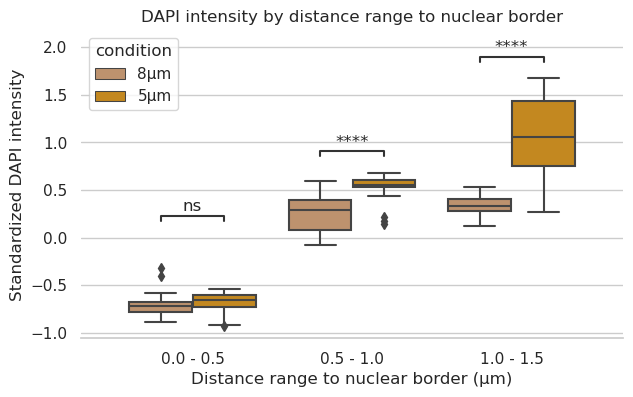

In [18]:
sns.set(rc={"figure.figsize": (7, 4)})
sns.set_style("whitegrid")

# Prepare pairs for statistical significance
pairs = []
for r in ("0.0 - 0.5", "0.5 - 1.0", "1.0 - 1.5"):
    pairs.extend([((r, "8μm"), (r, "5μm"))])

# Plot boxplot of intensity by distance interval
subset_df = nuc_df[nuc_df["condition"].isin(["8μm", "5μm"])]
subset_df.reset_index(drop=True, inplace=True)

subset_df = subset_df[
    subset_df["interval"].isin(["0.0 - 0.5", "0.5 - 1.0", "1.0 - 1.5"])
]
b = sns.boxplot(
    data=subset_df,
    x="interval",
    y="intensity",
    hue="condition",
    palette=palette,
)

# Plot statistical significance on top
annotator = Annotator(
    ax=b,
    data=subset_df,
    x="interval",
    y="intensity",
    hue="condition",
    pairs=pairs,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

# Figure aesthetic parameters
plt.title("DAPI intensity by distance range to nuclear border")
plt.xlabel("Distance range to nuclear border (μm)")
plt.ylabel("Standardized DAPI intensity")
sns.despine(left=True)
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5 - 1.0_Aged vs. 0.5 - 1.0_Aged + Ri: Mann-Whitney-Wilcoxon test two-sided, P_val:3.131e-03 U_stat=1.430e+04
1.0 - 1.5_Young vs. 1.0 - 1.5_Aged: Mann-Whitney-Wilcoxon test two-sided, P_val:3.610e-05 U_stat=1.076e+04
1.0 - 1.5_Aged vs. 1.0 - 1.5_Aged + Ri: Mann-Whitney-Wilcoxon test two-sided, P_val:1.023e-06 U_stat=1.572e+04
1.5 - 2.0_Young vs. 1.5 - 2.0_Aged: Mann-Whitney-Wilcoxon test two-sided, P_val:7.270e-01 U_stat=1.483e+04
1.5 - 2.0_Aged vs. 1.5 - 2.0_Aged + Ri: Mann-Whitney-Wilcoxon test two-sided, P_val:6.081e-02 U_stat=1.336e+04
0.0 - 0.5_Young vs. 0.0 - 0.5_Aged: Mann-Whitney-Wilcoxon test two-sided, P_val:4.557e-02 U_stat=1.633e+04
0.0 - 0.5_Aged vs. 0.0 - 0.5_Aged + Ri: Mann-Whitney-Wilcoxon test two-sided, P_val:1.131e-07 U_stat=7.793e+03
0.5 - 1.0_Young vs. 0.5 - 1.0_Aged: Mann-Wh

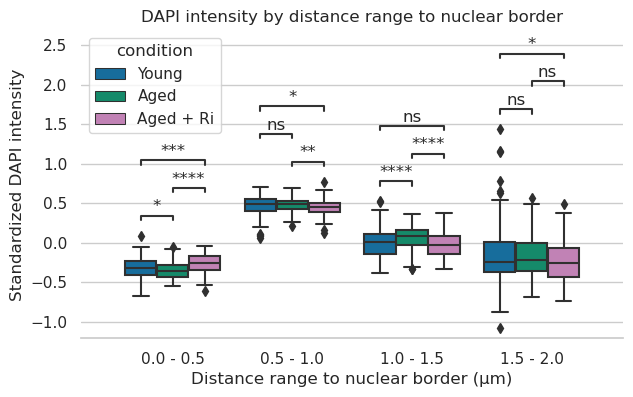

In [19]:
subset_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri"])]
subset_df.reset_index(drop=True, inplace=True)

# Prepare pairs for statistical significance
pairs = []
for r in ("0.0 - 0.5", "0.5 - 1.0", "1.0 - 1.5", "1.5 - 2.0"):
    pairs.extend(
        [
            ((r, "Young"), (r, "Aged")),
            ((r, "Young"), (r, "Aged + Ri")),
            ((r, "Aged"), (r, "Aged + Ri")),
        ]
    )

# Plot boxplot of intensity by distance interval
b = sns.boxplot(
    data=subset_df,
    x="interval",
    y="intensity",
    hue="condition",
    palette=palette,
)

# Plot statistical significance on top
annotator = Annotator(
    ax=b,
    data=subset_df,
    x="interval",
    y="intensity",
    hue="condition",
    pairs=pairs,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()
plt.title("DAPI intensity by distance range to nuclear border")
plt.xlabel("Distance range to nuclear border (μm)")
plt.ylabel("Standardized DAPI intensity")
sns.despine(left=True)
plt.show()